在开始前，我们需要生成我们训练用的训练集。因为我们是不专业的线性回归学习过程，所以测试集生不生成也不是特别重要。虽然我们说定了想要卖瓜，当然我们没有西瓜的销售数据，所以我直接自己生成。世界万物大部分数据均符合正态分布，所以我们使用正态分布生成我们的训练集。其实为了简单我们可以自己定义 w （权重）和 b （偏差），但是为了真实，也是添加一些挑战性，我们使用了可能存在单价与随机的数量。主要还是我们的模型还是太简单了。🤣

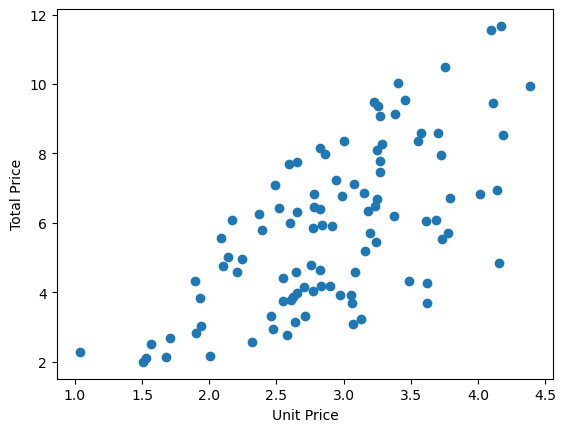

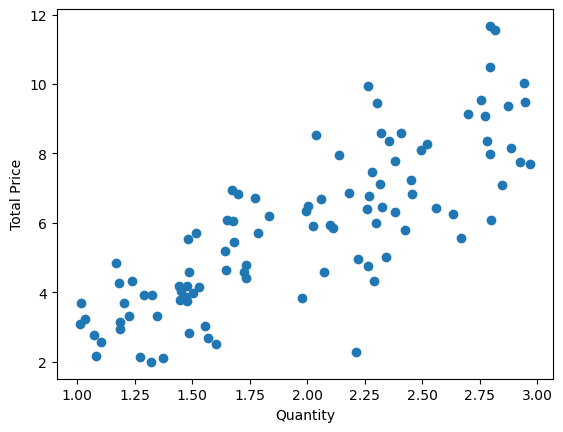

In [474]:
# Gerenates the traning set of watermelon price.
# We assume the unit price of watermelon is 3.
import numpy as np
import matplotlib.pyplot as plt

mu, sigma = 3, 0.75  # Average value is 3, and standard deviation is 0.75.

np.random.seed(42)
unit_price_of_watermelon = np.random.normal(mu, sigma, 100)
quantity_of_watermelon = np.random.uniform(1, 3, 100)
total_price_of_watermolen = unit_price_of_watermelon * quantity_of_watermelon

fig, ax = plt.subplots()
ax.set_xlabel("Unit Price")
ax.set_ylabel("Total Price")
plt.scatter(unit_price_of_watermelon, total_price_of_watermolen)
plt.show()

fig, ax = plt.subplots()
ax.set_xlabel("Quantity")
ax.set_ylabel("Total Price")
plt.scatter(quantity_of_watermelon, total_price_of_watermolen)
plt.show()


从上图可以观察到，单价和数量与总价总有一种隐隐约约的线性关系。现在，我们要看开始着手训练我们的模型了。首先我们有一个能够获得一些随机的数据的方法来选取训练的数据。

In [470]:
import random

def pick_data_from_training_set(x: np.ndarray, y: np.ndarray, batch_size: int):
    max_len = 100
    indices = list(range(max_len))
    random.shuffle(indices)

    for i in range(0, max_len, batch_size):
        batch_indices = indices[i : min(i + batch_size, max_len)]
        yield x[batch_indices], y[batch_indices]

for x, y in pick_data_from_training_set(unit_price_of_watermelon, total_price_of_watermolen, 10):
  print(x, y)
  break

[2.10284503 2.76809072 2.54952098 2.86075577 3.08319194 3.22209021
 2.62368222 3.14764593 3.24656333 3.25771372] [4.59408692 6.78324871 7.52549887 5.27363692 4.06700569 4.31604078
 4.67582956 7.24163592 4.92265641 8.09676416]


现在我们就能通过函数 `pick_data_from_traning_set`  来获取随机某一部分训练集的数据。获取这些数据，我们就可以进行训练了。我们先生成我们的参数 w （权重） 和 b （偏差）。在定义我们的模型和误差函数。

In [471]:
w = np.random.normal(0, 0.01, 1)
b = np.zeros(1)


def linear_regression(w: np.ndarray, x: np.ndarray, b: np.ndarray):
    return w * x + b


def mse(y_hat: np.ndarray, y: np.ndarray):
    return (y_hat - y) ** 2


net = linear_regression
loss = mse

下一步我需要求出 `mse` 函数的导数，准确地说是权重 w 和 偏差 b 的偏导数。在熟悉的深度学习框架，例如 Pytorch 或 TensorFlow 等框架中，都会通过自动微分来隐式生成导数函数。至于为什么需要 w 和 b 的偏导数，那就不得不提一个数学方法 “最小二乘法”。我们的目的就是让我们的 w 与 b 逼近真实的 w 和 b。在我们通过预测的 `y_hat` 与真实的 `y` 求出的误差就能反推出我们正在学习的 w 和 b 与真实的 w 和 b 之间的差距。通过缩小这个差距，我们就能逼近真实结果，也就是 `y`。缩小这个差距的方法就是 “最小二乘法”。通过求 w 和 b 的偏导数，从而得出梯度。就能根据学习率从而缩减差距。那么，让我们开始训练吧。

In [458]:
def sgd(
    params: list[np.ndarray],
    lr: float,
    batch_size: int,
):
    params[0] -= lr * params[1]
    params[1] -= lr * params[2]


# learning rate
lr = 0.05
batch_size = 10
max_epochs = 10


def traning():
    for epoch in range(max_epochs):
        for x, y in pick_data_from_training_set(
            unit_price_of_watermelon, total_price_of_watermolen, batch_size
        ):
            global w
            global b
            l = loss(net(w, x, b), y).sum()
            # print("l=", l)
            w_gradient = (2 / batch_size) * (w * (x**2).sum() - ((y - b) * x).sum())
            b_gradient = (2 / batch_size) * (batch_size * b - (y - w * x).sum())
            # print(w_gradient, b_gradient)
            w -= lr * w_gradient
            b -= lr * b_gradient
            # print("w =", w)
            # print("b =", b)
            # print()

            # sgd([w, w_hat, b, b_hat], lr, batch_size)


traning()
print(w, b)


w_up = (total_price_of_watermolen * (unit_price_of_watermelon - unit_price_of_watermelon.mean())).sum()
w_down = (unit_price_of_watermelon**2).sum() - (unit_price_of_watermelon.sum() ** 2) / batch_size
w_hat = w_up / w_down
b_hat = (unit_price_of_watermelon - w_hat * unit_price_of_watermelon).sum() / batch_size

print(w_hat, b_hat)

[3.09661555] [1.2051129]
-0.018037569303091198 29.74822965797918
